# <u>Neural/AI Search applied to Proxy Logs</u>

The intention of this Jupyter notebook is to examine how we might apply AI search to security logs.  We'll be using fabricated proxy logs that (in theory) show benign behavior, malicious behavior, and a 950/50 mix of those two. I hope to demonstrate the following three examples:
- Semantic matching: Compare incoming logs to a vector DB of known malicious logs, flagging matches for alert
- Anomaly detection: Compare incoming logs to a vector DB of known benign logs, flagging possible anomalies for alert
- Full-text Clustering: Show clustering done with full text by leveraging vector embeddings

We'll be using a simple development-grade vector datastore called ChromaDB, and a locally-running HuggingFace LLM (large language model) that is a common one of calculating generic vector embeddings of text.

Note that there are many synonyms for <b>vector search</b>...here's a list:
- Vector similarity search
- Semantic similarity search
- Neural search (because of it's basis in neural network models for the embeddings)
- AI search
- KNN search (K-Nearest Neighbors...this is the old and/or conceptual name)
- ANN search (Approximate Nearest Neighbors) 
- HNSW (Hierarchical Navigable Small World) search (the most popular approximation algorithm)
- Probably a few others I've forgotten

All of these synonyms are referring to the same concepts and technology. It's worth noting that vector search technology has been used in large scale recommendation systems, fraud detection systems, and other "big data" types of applications for nearly a decade. In fact, handling very large volumes of full-text data is exactly what this technology was invented to handle. It's also worth noting that vector embeddings are not just relevant to text...given a suitable ML model, vector embeddings can be captured for images, audio, video, even binary executables and encrypted data. 

In [1]:
import os, sys
import pandas as pd 
import chromadb
#from chromadb.config import DEFAULT_TENANT, DEFAULT_DATABASE, Settings

# <u>Semantic Matching: Match incoming logs against known malicious logs</u>
## Step 1: Hydrate vector DB of malicious logs
We can use this vectorstore of known malicious logs as reference data to compare incoming logs against to determine if any of those events are similar enough to raise an alert.  

In [2]:
# This CSV file contains fabricated proxy logs that are examples of malicious activity attempts
df = pd.read_csv('proxy_logs_malicious.csv')
df.columns

Index(['ID', 'IP Address', 'Timestamp', 'Log Entry'], dtype='object')

In [3]:
df.sample(3) # I've purposefully generated these to look like something that might be extracted from Splunk

,ID,IP Address,Timestamp,Log Entry
988,989,197.29.249.201,01/Aug/2024:12:48:49,"GET http://www.example.com/admin HTTP/1.1"" 403..."
924,925,167.184.188.90,01/Aug/2024:12:46:27,GET http://www.example.com/login.php?user=admi...
895,896,239.87.175.102,01/Aug/2024:18:48:48,"GET http://www.example.com/admin HTTP/1.1"" 403..."


In [4]:
# setup Chroma in-memory, for easy prototyping. Can add persistence easily!
client = chromadb.Client()
#client = chromadb.PersistentClient(path='./chromadb_proxy_logs')  # A bug prevents this from working

In [5]:
# Create collection. get_collection, get_or_create_collection, delete_collection also available
# ChromaDB uses L2 (Euclidean distance) by default...we want Cosine metric.
# Cosine similarity -> higher = better
collection = client.get_or_create_collection(name='malicious_proxy_logs', metadata={"hnsw:space": "cosine"})

In [6]:
# Create lists of the necessary data from the dataframe
ID_list = df['ID'].astype(str).tolist()  # ID list, converted to string
LogEntry_list = df['Log Entry'].tolist()   # List of documents (log content)

In [7]:

# Add docs to the collection. Can also update and delete.
# We are letting ChromaDB automatically calculate the vector embedding, instead of explicitly handling it
# By default, ChromaDB uses all-MiniLM-L6-v2 sentence transformer model to calculate vector embeddings
# This all-MiniLM-L6-v2 model provides a 384 dimension vector that can be used for embedding and clustering
collection.add(
    documents=LogEntry_list, # we handle tokenization, embedding, and indexing automatically. You can skip that and add your own embeddings as well
    #metadatas=[{"source": "notion"}, {"source": "google-docs"}], # metadata filters
    ids=ID_list, # unique ID for each doc
)

In [8]:
collection.count()  # Check our count to make sure it looks right

1000

In [9]:
# Examine a record by ID...tell it to show the vector embedding so we can see what it looks like
# The vector embedding is the 384 dimension numeric representation of what that text "means"...
collection.get('1', include=['embeddings', 'documents', 'metadatas'])
#collection.get(['1','2'], include=['embeddings', 'documents', 'metadatas'])

{'ids': ['1'],
 'embeddings': [array([ 7.62485852e-03,  4.53667305e-02, -4.74873595e-02,  6.38289424e-03,
          1.04712076e-01, -9.29494649e-02,  3.30195762e-03, -2.59210616e-02,
          5.31232208e-02, -9.98799801e-02, -1.34964027e-02,  2.52751410e-02,
          9.09934863e-02, -2.30148784e-03, -3.68964337e-02,  2.72639599e-02,
         -3.08614544e-05,  1.75895784e-02,  4.42130752e-02, -4.82321531e-02,
          9.13773328e-02,  3.76302861e-02,  4.21186276e-02, -8.69319122e-03,
         -7.84153715e-02, -4.20195386e-02, -3.71134132e-02, -1.43288216e-02,
          3.94372605e-02,  7.00980704e-03,  4.29793000e-02, -1.34540960e-01,
          1.49487145e-02, -1.01147126e-02,  6.74820086e-03, -2.62145475e-02,
          2.07935330e-02,  5.18131116e-03,  1.60162561e-02, -8.18299782e-03,
         -7.13483337e-03, -1.71514926e-03,  5.44389822e-02,  5.02826646e-02,
         -1.11683058e-02, -3.28837633e-02, -8.96301419e-02, -5.58557063e-02,
         -8.27203915e-02, -8.97455681e-03, -4.6

In [10]:
# Let's examine simple calcs around vector distance to foster understanding
import numpy
import math
from scipy import spatial

# Grab data from two of the records we've put into the vector DB to examine
vec1 = collection.get('1', include=['embeddings', 'documents'])['embeddings'][0]
vec2 = collection.get('2', include=['embeddings', 'documents'])['embeddings'][0]

# Calc the euclidean (or L2) distance between those two vectors
# This is the same thing you'd do with geographic distance between 2 cities
# Euclidean provides magnitude but not direction...a lower distance is better match
euclidean_dist = spatial.distance.euclidean(vec1, vec2)
print('euclidean distance: ', euclidean_dist)

# Cosine similarity is the difference between angles...it provides direction but not magnitude
# Cosine is often a good metric for text comparison...not that a higher value is better match
cosine_dist = spatial.distance.cosine(vec1, vec2)
print('cosine similarity: ', cosine_dist)


euclidean distance:  0.8742813467979431
cosine similarity:  0.38218384981155396


In [11]:
# Execute an ANN query/search for K most similar results.
results = collection.query(
    query_texts=["http://www.example.com/../../etc/passwd"], # This gets vectorized and used for vector query
    n_results=3,
    # where_document={"$contains":"Macintosh"}  # optional keyword filter
    # where={"metadata_field": "is_equal_to_this"}, # optional metadata filter
)

results

{'ids': [['660', '620', '149']],
 'distances': [[0.3781334161758423, 0.3815879225730896, 0.3835199475288391]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['GET http://www.example.com/../../etc/passwd HTTP/1.1" 500 322256 "http://www.example.com/../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/../../etc/passwd HTTP/1.1" 400 190721 "http://www.example.com/../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 400 128469 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15']],
 'uris': None,
 'data': None}

In [12]:
# Ask the same question, but this time in plain English!
results = collection.query(
    query_texts=["Can you show me possible attempts to change a password?"],  # Vectorize and search
    n_results=3,
    # where_document={"$contains":"script"}  # optional keyword filter
    # where={"metadata_field": "is_equal_to_this"}, # optional metadata filter
)

results

{'ids': [['730', '573', '153']],
 'distances': [[0.6075342893600464, 0.6118622422218323, 0.6151671409606934]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 580156 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 530538 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
   'GET http://www.example.com/index.php?page=../../../../../../etc/passwd HTTP/1.1" 403 190296 "http://www.example.com/index.php?page=../../../../../../etc/passwd" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, 

# Step 2: Semantic matching of malicious attempts
We have a vector DB of malicious logs to execute neural searches against.  Now, let's feed it some fresh logs to see what matches we get.  We want to use cosine similarity for this.  We'll have to experiment a bit to set a reasonable threshold for when to return an alert vs not.

In [13]:
# Some fabricated proxy logs that contain 950 benign log entries and 50 malicious log entries
df = pd.read_csv('proxy_logs_mixed.csv')

In [14]:
df.sample(3)

,ID,IP Address,Timestamp,Log Entry
860,861,28.57.14.53,01/Aug/2024:16:57:04,"GET http://update.software.com/check HTTP/1.1""..."
912,913,238.105.237.63,01/Aug/2024:04:21:56,GET http://update.software.com/version.xml HTT...
814,815,112.155.209.211,01/Aug/2024:03:59:27,"GET http://www.example.com/style.css HTTP/1.1""..."


In [15]:
incoming_proxy_logs = df['Log Entry']
incoming_proxy_logs

0      GET http://www.example.com/ HTTP/1.1" 200 4516...
1      GET http://intranet.company.com/home HTTP/1.1"...
2      GET http://update.software.com/check HTTP/1.1"...
3      GET http://update.software.com/version.xml HTT...
4      GET http://www.example.com/ HTTP/1.1" 200 6339...
                             ...                        
995    GET http://www.example.com/admin HTTP/1.1" 400...
996    GET http://www.example.com/admin HTTP/1.1" 403...
997    GET http://www.example.com/../../etc/passwd HT...
998    GET http://www.example.com/admin HTTP/1.1" 403...
999    GET http://www.example.com/search?q=<script>al...
Name: Log Entry, Length: 1000, dtype: object

In [16]:
# Find incoming log entries that match known malicious activity at a pre-determined threshold 
for log_entry in incoming_proxy_logs:
    results = collection.query(
    query_texts=log_entry,
    n_results=1,
    # where={"metadata_field": "is_equal_to_this"}, # optional filter
    # where_document={"$contains":"search_string"}  # optional filter
    )
    if results['distances'][0][0] >= 0.488:  # Threshold for a match
       print(f'Possible alert on: {log_entry} \n  -- Match within threshold on {results}')

Possible alert on: GET http://cloudstorage.com/files HTTP/1.1" 200 365923 "http://cloudstorage.com/files" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36 
  -- Match within threshold on {'ids': [['663']], 'distances': [[0.49013596773147583]], 'metadatas': [[None]], 'embeddings': None, 'documents': [['GET http://www.example.com/admin HTTP/1.1" 400 842410 "http://www.example.com/admin" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15']], 'uris': None, 'data': None}
Possible alert on: GET http://cloudstorage.com/files HTTP/1.1" 200 142231 "http://cloudstorage.com/files" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.81 Safari/537.36 
  -- Match within threshold on {'ids': [['663']], 'distances': [[0.4895135164260864]], 'metadatas': [[None]], 'embeddings': None, 'documents': [['GET http://www.exampl

# <u>Anomaly Detection by AI search on Benign Logs</u>
## Step 1: Build vector DB of Benign Proxy log data

In [18]:
# To conserve memory, re-use the previous collection for new data
collection = client.get_or_create_collection(name='benign_proxy_logs', metadata={"hnsw:space": "cosine"})

In [19]:
# This CSV file contains fabricated proxy logs that are examples of benign activity
df = pd.read_csv('proxy_logs_good.csv')
df.sample(3)

,ID,IP Address,Timestamp,Log Entry
361,362,184.173.69.98,01/Aug/2024:10:15:50,"GET http://www.example.com/script.js HTTP/1.1""..."
959,960,12.240.36.59,01/Aug/2024:18:07:02,"GET http://update.software.com/check HTTP/1.1""..."
958,959,225.144.179.9,01/Aug/2024:11:16:20,"GET http://cloudstorage.com/login HTTP/1.1"" 20..."


In [20]:
# Create lists of the necessary data from the dataframe
ID_list = df['ID'].astype(str).tolist()  # ID list, converted to string
LogEntry_list = df['Log Entry'].tolist()   # List of documents (log content)

In [21]:
# Add log records to vector store, allowing ChromaDB to calculate vector embeddings
collection.add(
    documents=LogEntry_list, # we handle tokenization, embedding, and indexing automatically. 
    #metadatas=[{"source": "notion"}, {"source": "google-docs"}], # metadata filters
    ids=ID_list, # unique ID for each doc
)

In [22]:
collection.count()  # Check our count to make sure it looks right

1000

In [23]:
# Check a few records...
collection.get(['1','2','3'])

{'ids': ['1', '2', '3'],
 'embeddings': None,
 'metadatas': [None, None, None],
 'documents': ['GET http://www.example.com/ HTTP/1.1" 200 140321 "http://www.example.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15',
  'GET http://update.software.com/check HTTP/1.1" 200 943292 "http://update.software.com/check" "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
  'GET http://www.example.com/ HTTP/1.1" 200 813021 "http://www.example.com/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15'],
 'uris': None,
 'data': None}

# Step 1: Vector search for Anomaly Detection
With a vector DB of known benign/good proxy log entries, we can do semantic comparison to flag incoming log entries that are too different from what we know to be benign logs. 

In [24]:
# We'll use fabricated proxy logs that contain 950 benign log entries and 50 malicious log entries again
df = pd.read_csv('proxy_logs_mixed.csv')
df.sample(3)

,ID,IP Address,Timestamp,Log Entry
637,638,41.129.83.221,01/Aug/2024:15:00:51,"GET http://intranet.company.com/home HTTP/1.1""..."
541,542,107.17.223.233,01/Aug/2024:08:37:35,"GET http://www.example.com/ HTTP/1.1"" 200 8591..."
792,793,188.24.59.130,01/Aug/2024:21:14:01,"GET http://www.example.com/ HTTP/1.1"" 200 2761..."


In [25]:
# Grab just the log entry iself
incoming_proxy_logs = df['Log Entry']
incoming_proxy_logs

0      GET http://www.example.com/ HTTP/1.1" 200 4516...
1      GET http://intranet.company.com/home HTTP/1.1"...
2      GET http://update.software.com/check HTTP/1.1"...
3      GET http://update.software.com/version.xml HTT...
4      GET http://www.example.com/ HTTP/1.1" 200 6339...
                             ...                        
995    GET http://www.example.com/admin HTTP/1.1" 400...
996    GET http://www.example.com/admin HTTP/1.1" 403...
997    GET http://www.example.com/../../etc/passwd HT...
998    GET http://www.example.com/admin HTTP/1.1" 403...
999    GET http://www.example.com/search?q=<script>al...
Name: Log Entry, Length: 1000, dtype: object

In [26]:
# Let's identify anomalies in the incoming logs by using vector search against DB of known benign logs
for log_entry in incoming_proxy_logs:
    results = collection.query(
    query_texts=log_entry,
    n_results=1,
    # where={"metadata_field": "is_equal_to_this"}, # optional filter
    # where_document={"$contains":"search_string"}  # optional filter
    )
    if results['distances'][0][0] <= 0.0001:  # Threshold for a non-match
       print(f'Possible anomaly on: {log_entry} \n  -- Different within threshold on {results}')

Possible anomaly on: GET http://intranet.company.com/docs/document.pdf HTTP/1.1" 200 937423 "http://intranet.company.com/docs/document.pdf" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15 
  -- Different within threshold on {'ids': [['250']], 'distances': [[9.751319885253906e-05]], 'metadatas': [[None]], 'embeddings': None, 'documents': [['GET http://intranet.company.com/docs/document.pdf HTTP/1.1" 200 787396 "http://intranet.company.com/docs/document.pdf" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15']], 'uris': None, 'data': None}
Possible anomaly on: GET http://cloudstorage.com/authenticate HTTP/1.1" 200 596569 "http://cloudstorage.com/authenticate" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15 
  -- Different within threshold on {'ids': [['597']], 'distances': [[

# <u>Full-text Clustering with Vector Embeddings</u>
We will use the mixed proxy log data which 950 benign logs + 50 malicious logs to see if we can segregate the two using clustering. This is a notable exercise...only recently has this technology advanced to the point that we can actually do Clustering with full text such as security logs!


In [27]:
import pandas as pd

# We'll use the mixed proxy logs to see if we can get them clustered into 950 benign + 50 malicious
df = pd.read_csv('proxy_logs_mixed.csv')
df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
df.sample(3)


,ID,Log Entry
439,440,"GET http://www.example.com/ HTTP/1.1"" 200 7928..."
370,371,GET http://cloudstorage.com/authenticate HTTP/...
131,132,GET http://intranet.company.com/docs/document....


In [28]:
# It's easier to just calc the vector embeddings explicitly, vs adding inserting to ChromaDB to get embeddings
# ChromaDB can't do clustering queries (yet), but we will use the same embedding model that ChromaDB is using

# Load the embedding model so we can use it to easily populate the dataframe
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
# Use like this: embeddings = model.encode(whatever_text)

# Use a lambda function to encode the text in each row and apply it to a new column
df['embedding'] = df['Log Entry'].apply(lambda text:model.encode(text))
df.sample(3)

c:\Users\david\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,ID,Log Entry,embedding
428,429,"GET http://www.example.com/style.css HTTP/1.1""...","[-0.014370509, 0.06218743, -0.007341928, 0.004..."
482,483,"GET http://update.software.com/check HTTP/1.1""...","[-0.011305338, -0.022801176, 0.008385229, -0.0..."
499,500,"GET http://cloudstorage.com/files HTTP/1.1"" 20...","[-0.019968366, 0.032466516, 0.018314362, -0.00..."


In [29]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Assuming you have a DataFrame `df` with columns: 'ID', 'text', and 'embedding'
# Here 'embedding' contains the 384-dimensional vectors

# Extract the embeddings from the DataFrame
embeddings = df['embedding'].tolist()

# Convert the list of embeddings into a numpy array
# import numpy as np
X = np.array(embeddings)

# Perform K-means clustering with K=2
# We know we have good logs and bad logs, so let's try to cluster them into good and bad
kmeans = KMeans(n_clusters=2, n_init=100, max_iter=3000, random_state=0)
#kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300, random_state=0)  # These are defaults
#kmeans = KMeans(n_clusters=2, n_init=10000, max_iter=10000, random_state=0)
df['cluster'] = kmeans.fit_predict(X)

# Now `df` will have a new column 'cluster' indicating the cluster each entry belongs to
df.columns


Index(['ID', 'Log Entry', 'embedding', 'cluster'], dtype='object')

In [30]:
df.sample(3)

,ID,Log Entry,embedding,cluster
751,752,GET http://intranet.company.com/docs/document....,"[-0.030695735, -0.0139138615, -0.04764395, -0....",1
482,483,"GET http://update.software.com/check HTTP/1.1""...","[-0.011305338, -0.022801176, 0.008385229, -0.0...",1
193,194,"GET http://cloudstorage.com/files HTTP/1.1"" 20...","[-0.018654734, 0.03096086, 0.019283162, -0.007...",0


In [31]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster'].value_counts()

cluster
1    711
0    289
Name: count, dtype: int64

In [32]:
# Let's try dimensionality reduction to 2 dimensions from 384, then try re-clustering
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Extract the embeddings from the DataFrame
embeddings = df['embedding'].tolist()

# Convert the list of embeddings into a numpy array
import numpy as np
X = np.array(embeddings)

# Perform PCA for dimensionality reduction
n_components = 2  # Number of dimensions to reduce to
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X)

# Add the principal components to the DataFrame
df_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])
df = pd.concat([df, df_pca], axis=1)

# Perform K-means clustering using the PCA components, and add a cluster2 column from that exercise
kmeans2 = KMeans(n_clusters=2, random_state=0)
df['cluster2'] = kmeans.fit_predict(df[['PC1', 'PC2']])


In [33]:
df.sample(3)

,ID,Log Entry,embedding,cluster,PC1,PC2,cluster2
76,77,GET http://intranet.company.com/docs/document....,"[-0.03190821, -0.016718246, -0.048723537, -0.0...",1,-0.159950,0.200674,1
944,945,"GET http://cloudstorage.com/login HTTP/1.1"" 20...","[-0.004704783, 0.017228182, 0.028731784, -0.04...",0,0.485012,0.097875,0
280,281,"GET http://www.example.com/style.css HTTP/1.1""...","[-0.026497563, 0.045002546, 0.014831711, 0.001...",1,-0.269218,-0.205852,1


In [34]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster2'].value_counts()

cluster2
1    711
0    289
Name: count, dtype: int64

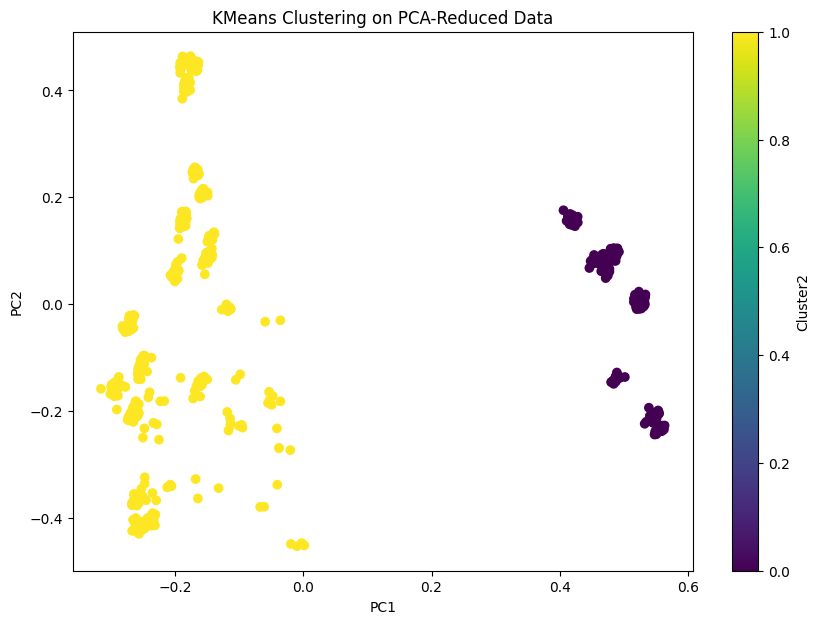

In [35]:
# Visualize the clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df['PC1'], df['PC2'], c=df['cluster2'], cmap='viridis', marker='o')
plt.title('KMeans Clustering on PCA-Reduced Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster2')
plt.show()

In [36]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_distances

# Convert the embeddings column to a numpy array
embeddings = np.array(df['embedding'].tolist())

# Standardize the data (optional but recommended)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Calculate the cosine distance matrix
cosine_dist_matrix = cosine_distances(embeddings_scaled)

# Perform DBSCAN clustering with cosine distance
# Parameters to adjust: `eps` (radius of neighborhood), `min_samples` (min points to form a cluster)
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='precomputed')
df['cluster3'] = dbscan.fit_predict(cosine_dist_matrix)

# Analyzing the results
n_clusters = len(set(df['cluster3'])) - (1 if -1 in df['cluster3'] else 0)
n_noise = list(df['cluster3']).count(-1)

print(f'Estimated number of DBSCAN clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

# If you want to see the first few entries and their clusters
df.columns


Estimated number of DBSCAN clusters: 8
Estimated number of noise points: 0


Index(['ID', 'Log Entry', 'embedding', 'cluster', 'PC1', 'PC2', 'cluster2',
       'cluster3'],
      dtype='object')

In [37]:
df.sample(3)

,ID,Log Entry,embedding,cluster,PC1,PC2,cluster2,cluster3
405,406,"GET http://update.software.com/check HTTP/1.1""...","[-0.009715447, -0.020859571, 0.008034416, -0.0...",1,-0.186221,0.405554,1,6
657,658,GET http://cloudstorage.com/authenticate HTTP/...,"[-0.030986777, 0.042051718, -0.036078013, -0.0...",0,0.561287,-0.234748,0,5
489,490,"GET http://www.example.com/script.js HTTP/1.1""...","[-0.037091374, 0.005927892, 0.010983176, -0.03...",1,-0.251328,-0.107507,1,3


In [38]:
# We hope to see cluster group counts in the ballpark of 950 and 50
df['cluster3'].value_counts()

# It appears that perhaps cluster 2 with 53 points might be our malicious logs, but...
# I'm not sure (yet) how we would determine that if we didn't already there were 50 bad logs

cluster3
5    289
1    182
6    142
0    138
3     95
4     86
2     53
7     15
Name: count, dtype: int64

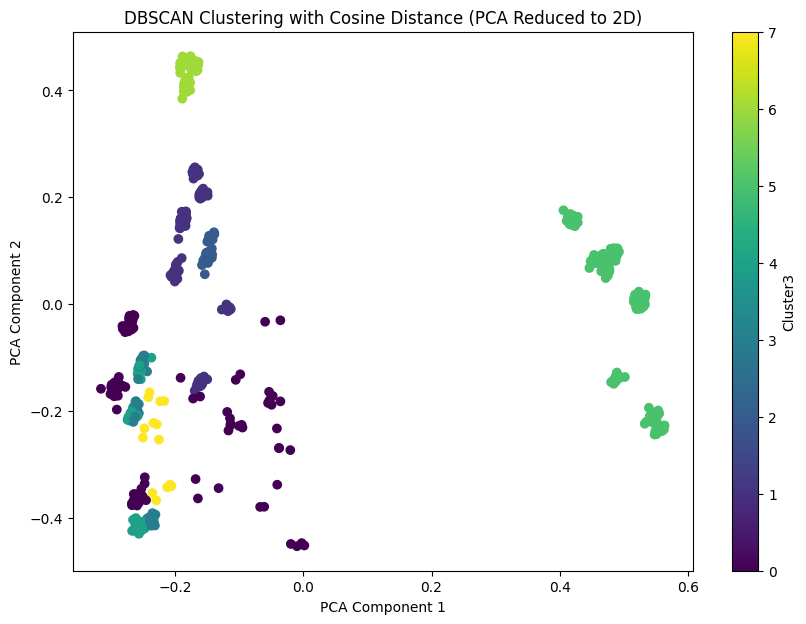

In [39]:
# Plot the results after applying PCA

# Reduce the embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df['cluster3'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering with Cosine Distance (PCA Reduced to 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster3')
plt.show()

# Now, where to?
Some areas for further research:
- Try different embedding models to determine which one performs best with proxy logs
- Dig deeper into the data to determine how we would be able to name clusters from DBSCAN
- Examine other clustering algorithms that might be more meaningful
